In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.filters import threshold_otsu
from skimage.segmentation import random_walker,watershed
from skimage.draw import line
from skimage.transform import rescale
from scipy.ndimage.filters import convolve
from scipy.ndimage.measurements import center_of_mass
from skimage.measure import regionprops
from cv2 import fillPoly
from Helper_Functions import Generate_Features, Quality_Evaluation
from shapely.geometry import Polygon
from skimage.morphology import closing,opening, disk
from skimage.filters.rank import entropy
from skimage.filters import gaussian
from skimage.morphology import remove_small_objects
from sklearn.ensemble import RandomForestClassifier
from skimage.segmentation import random_walker
from multiprocessing import cpu_count
from skimage.morphology import opening, disk,remove_small_holes,remove_small_objects
import os
from sklearn.externals import joblib
import skvideo.io
%matplotlib inline

In [2]:
RF = joblib.load('KITI_RandomForest.pkl')
print("Random Forest Model Loaded")

Random Forest Model Loaded


In [3]:
def rgb2c1c2c3(I):

    R=I[:,:,0]/255
    G=I[:,:,1]/255
    B=I[:,:,2]/255

    c1=np.arctan2(R,np.maximum(G,B))/(np.pi/2)
    c2=np.arctan2(G,np.maximum(R,B))/(np.pi/2)
    c3=np.arctan2(B,np.maximum(R,G))/(np.pi/2)

    #c1=mat2gray(c1)*255;
    #c2=mat2gray(c2)*255;
    #c3=mat2gray(c3)*255;

    return c1,c2,c3

In [4]:
def Compute_Derivatives(c1,c2):

    C1x=convolve(c1,0.25*np.array([[-1., 1.], [-1., 1.]]))+convolve(c2, 0.25*np.array([[-1., 1.], [-1., 1.]]))
    C1y=convolve(c1,0.25*np.array([[-1., -1.], [1., 1.]]))+convolve(c2, 0.25*np.array([[-1., -1.], [1., 1.]]))
    C1t=convolve(c1, 0.25*np.ones([2,2]))+convolve(c2, -0.25*np.ones([2,2]))

    return C1x,C1y,C1t

In [5]:
def Compute_HSC1(c1,c2,a,k,vx,vy):
    c1=rescale(c1,4,preserve_range=True)
    c2=rescale(c2,4,preserve_range=True)
    vx=rescale(vy,4,preserve_range=True)
    vy=rescale(vy,4,preserve_range=True)
    C1x,C1y,C1t=Compute_Derivatives(c1,c2)

    Mask=np.array([[1./12., 1./6., 1./12.],[1./6., 0., 1./6.],[1./12., 1./6., 1./12.]])

    m,n=C1x.shape

    Vx=np.zeros([m,n])
    Vy=np.zeros([m,n])
    V=np.zeros([m,n])

    for i in range(k):
        Vx = vx - (C1x*((C1x*vx)+(C1y*vy)+C1t))/(a**2+C1x**2+C1y**2)
        Vy = vy - (C1y*((C1x*vx)+(C1y*vy)+C1t))/(a**2+C1x**2+C1y**2)
        
        vx=convolve(Vx,Mask)
        vy=convolve(Vy,Mask)
        
    V=np.sqrt(Vx**2+Vy**2)
    
    V=entropy(V/np.max(V),selem=np.ones([3,3]))
    V=rescale(V,0.25,preserve_range=True)
    Vx=rescale(Vx,0.25,preserve_range=True)
    Vy=rescale(Vy,0.25,preserve_range=True)
    vx=rescale(vy,0.25,preserve_range=True)
    vy=rescale(vy,0.25,preserve_range=True)
    return V,Vx,Vy,vx,vy

In [6]:
def Generate_Non_Road_Seeds(V,sky_height):
    thresh = threshold_otsu(V)
    Non_Road_Seeds = V > thresh
    Sky=np.zeros(V.shape, dtype=bool)
    Sky[0:sky_height,:]=True
    Non_Road_Seeds=Non_Road_Seeds|Sky
    selem = disk(3)
    Non_Road_Seeds=opening(Non_Road_Seeds,selem)
    
    return Non_Road_Seeds

In [7]:
def Generate_Road_Seeds(Image):
    nx,ny=Image.shape[0:2]
    Test_Features=np.reshape(Generate_Features(Image),[54,nx*ny]).T
    Prediction = RF.predict_proba(Test_Features)
    Prediction = Prediction.reshape([nx,ny,2])
    Road_Seeds=Prediction[:,:,1]>0.4
    Road_Seeds[0:round(nx/2),:]=False
    selem = disk(7)
    Road_Seeds=opening(Road_Seeds,selem)
    return Road_Seeds

In [8]:
def Get_Image_and_Ground_Truth(path):
    GT=[]
    Im=[]
    for file in os.listdir(path):
        if file.endswith("-L.png"):
            Im.append(file)
    for file in os.listdir(path):
        if file.endswith("-L.txt"):
            GT.append(file)  

    GT=sorted(GT)
    Im=sorted(Im)
    return GT,Im

In [9]:
def Generate_Ground_Truth(filename,nx,ny):

    with open(filename) as GT:
        Result = [line.split(' ') for line in GT.readlines()]

    for i in range(len(Result)):
        Result[i][-1]=Result[i][-1].rstrip("\n")

    rX=[]
    rY=[]
    for j in range(len(Result)):
        if Result[j][0]=="road":
            for i in range(2,len(Result[j]),2):
                rX.append(float(Result[j][i]))

            for i in range(3,len(Result[j]),2):
                rY.append(float(Result[j][i]))


            rX.append(rX[0])
            rY.append(rY[0])

            rX=320*np.array(rX)
            rY=240*np.array(rY)

    OX=[]
    OY=[]
    for j in range(len(Result)):
        oX=[]
        oY=[] 
        if Result[j][0]=="occl":
            for i in range(2,len(Result[j]),2):
                oX.append(float(Result[j][i]))

            for i in range(3,len(Result[j]),2):
                oY.append(float(Result[j][i]))


            oX.append(oX[0])
            oY.append(oY[0])

            oX=320*np.array(oX)
            oY=240*np.array(oY)
        OX.append(oX)
        OY.append(oY)
    road = Polygon(zip(rX,rY))
    Ground_Truth=np.zeros((nx,ny))

    x, y = road.exterior.coords.xy

    x.tolist()
    y.tolist()
    x= [ int(m) for m in x ]
    y= [ int(m) for m in y ]

    z=list(zip(x,y))
    fillPoly(Ground_Truth, [np.array(z)], 1)
    Ground_Truth=Ground_Truth==1
    return(Ground_Truth)

In [10]:
#  1:   0 - 450 (450 frames)
#  2: 451 - 601 (100 frames)
#  3: 602 - 702 (100 frames)
#  4: 703 - 763 ( 60 frames)
#  5: 764 - 864 (100 frames)
def Run(sigma=1,a=0.1,k=3,beta=135):
    path="/home/thanos/Desktop/Project_ADAS_2017/DiploDoc/gtseq"
    GT=[]
    Im=[]
    Pr=[]
    Co=[]
    Qu=[]
    GT,Im=Get_Image_and_Ground_Truth(path)
    #Video
    writer = skvideo.io.FFmpegWriter("Random_Forest_Diplodoc_All_Sequences.avi")
    ############################################3
  
    start=1
    stop=864
    for i in range(start,stop):   
        I0=imread(path+"/"+Im[i-1])
        I1=imread(path+"/"+Im[i])
        filename=path+"/"+GT[i]
        c0=rgb2c1c2c3(I0)[0]
        c1=rgb2c1c2c3(I1)[0]
        #c0=gaussian(c0,sigma=sigma)
        #c1=gaussian(c1,sigma=sigma)

        C1x,C1y,C1t=Compute_Derivatives(c0,c1)
        nx,ny=I0[:,:,0].shape
        vx=np.zeros([nx,ny])
        vy=np.zeros([nx,ny])
                                 
        V,Vx,Vy,vx,vy=Compute_HSC1(c0,c1,a,k,vx,vy)
        
        Non_Road_Seeds=Generate_Non_Road_Seeds(V,50)
        #Non_Road_Seeds=remove_small_objects(Non_Road_Seeds, min_size=500)
       
        Road_Seeds=Generate_Road_Seeds(I1)
        Road_Seeds=Road_Seeds&(~Non_Road_Seeds)    
        labels=np.zeros(V.shape, dtype=int)
        labels[Non_Road_Seeds]=1
        labels[Road_Seeds]=2

        
        Segmentation=random_walker(gaussian(I1,sigma=sigma), labels, beta=beta, multichannel=True)

        Temp=I1.copy()
        Temp[:,:,2][Non_Road_Seeds]=255
        Temp[:,:,0][Segmentation==2]=255
        Temp[:,:,1][Road_Seeds]=255


        plt.figure(figsize=(3,2))
        plt.imshow(Temp, cmap='gray')
        plt.title("frame = {}".format(i))
        plt.axis('off')
        plt.show()
        writer.writeFrame(Temp)

        Final_Road_Region=Segmentation==2
        Ground_Truth=Generate_Ground_Truth(filename,nx,ny)
        p, c, q = Quality_Evaluation(Final_Road_Region,Ground_Truth)
        Pr.append(p)
        Co.append(c)
        Qu.append(q)
    writer.close()    
    return Pr,Co,Qu


In [11]:
def Visualise_Results(Pr,Co,Qu):
    Pr=np.array(Pr)
    Co=np.array(Co)
    Qu=np.array(Qu)

    mean_Pr=np.mean(Pr)
    mean_Co=np.mean(Co)
    mean_Qu=np.mean(Qu)

    var_Pr=np.var(Pr)
    var_Co=np.var(Co)
    var_Qu=np.var(Qu)

    max_Co=np.max(Co)
    min_Co=np.min(Co)

    max_Pr=np.max(Pr)
    min_Pr=np.min(Pr)

    max_Qu=np.max(Qu)
    min_Qu=np.min(Qu)

    plt.figure()
    plt.title("Random_Forest_All_Sequences Precision,Recall,Quality")
    plt.plot(Pr)
    plt.plot(Co)
    plt.plot(Qu)
    plt.xlabel("frames")
    axes = plt.gca()
    axes.set_ylim([0.5,1.05])
    plt.legend(['Precision','Recall','Quality'])
    plt.savefig("Random_Forest_All_Sequences.eps")
    plt.show()

    print("Random_Forest_All_Sequences- Random Walker Results")
    print("Precision")
    print("Mean, Var, max, min")
    print(mean_Pr,var_Pr,max_Pr,min_Pr)
    print("Recall")
    print(mean_Co,var_Co,max_Co,min_Co)
    print("Quality")
    print(mean_Qu,var_Qu,max_Qu,min_Qu)

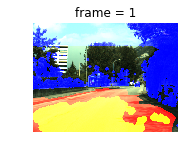

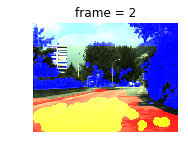

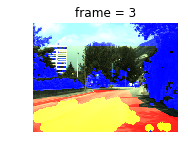

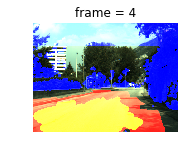

KeyboardInterrupt: 

In [12]:
Pr,Co,Qu=Run(sigma=1,a=0.5,k=15,beta=2500)

In [ ]:
Visualise_Results(Pr,Co,Qu)